In [1]:
import math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
train=pd.read_csv('energy/train.csv', encoding='cp949')
test=pd.read_csv('energy/test.csv', encoding='cp949')
submission=pd.read_csv('energy/sample_submission.csv', encoding='cp949')

In [3]:
train[['num', '비전기냉방설비운영','태양광보유']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'비전기냉방설비운영']
    hot[count]=train.loc[i,'태양광보유']
    
for i in range(len(test)):
    test.loc[i, '비전기냉방설비운영']=ice[test['num'][i]]
    test.loc[i, '태양광보유']=hot[test['num'][i]]

In [4]:
def time(x):
    return int(x[-2:])
train['hour']=train['date_time'].apply(lambda x: time(x))
test['hour']=test['date_time'].apply(lambda x: time(x))

def weekday(x):
    return pd.to_datetime(x[:10]).weekday()
train['weekday']=train['date_time'].apply(lambda x :weekday(x))
test['weekday']=test['date_time'].apply(lambda x :weekday(x))

In [5]:
test.interpolate(method='values', inplace=True)

In [6]:
train['date_time'] = pd.to_datetime(train['date_time'].apply(lambda x: str(x)+':00'))
test['date_time'] = pd.to_datetime(test['date_time'].apply(lambda x: str(x)+':00'))

k: 2, inertia : 141731596052.6865
k: 3, inertia : 93263968980.8303
k: 4, inertia : 67366933376.6103
k: 5, inertia : 56459648679.0319
k: 6, inertia : 47063655777.2855
k: 7, inertia : 40041384909.0536
k: 8, inertia : 32744351078.3215
k: 9, inertia : 27965201748.6183
k: 10, inertia : 24313672662.1185


Text(0, 0.5, 'inertia')

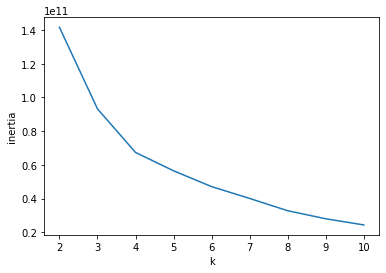

In [7]:
cluster_df = train['전력사용량(kWh)'].values.reshape(60, -1)

inertia_arr = []
k_arr = range(2, 11)

for k in k_arr:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=0)
    kmeans.fit(cluster_df)
    interia = kmeans.inertia_
    
    print('k: {0}, inertia : {1:.4f}'.format(k, interia))
    inertia_arr.append(interia)

plt.plot(k_arr, inertia_arr)
plt.xlabel('k')
plt.ylabel('inertia')

In [8]:
cluster_df = train.iloc[:, :3].drop('date_time', axis=1)
cluster_df

,num,전력사용량(kWh)
0,1,8179.056
1,1,8135.640
2,1,8107.128
3,1,8048.808
4,1,8043.624
...,...,...
122395,60,4114.368
122396,60,3975.696
122397,60,3572.208
122398,60,3299.184


**2040 = 85 * 24**

일자별 클러스터

In [9]:
hour_df = pd.DataFrame(train.hour.unique(), columns=['hour'])
num_df = pd.DataFrame(train.num.unique(), columns=['num'])
num_hour_df = pd.DataFrame(train.num.unique(), columns=['num'])

In [10]:
#feature = time, 시간별 insert

hour_cluster = pd.DataFrame(np.array(train.groupby(['date_time']).mean().iloc[:,1]).reshape(-1, 24).T)

kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
kmeans.fit(hour_cluster)
clusters = kmeans.predict(hour_cluster)

hour_df['hour_assignment'] = clusters
train = train.merge(hour_df, how='left', on='hour')
test = test.merge(hour_df, how='left', on='hour')

In [11]:
#feature = num, 건물별 insert

num_cluster = pd.DataFrame(np.array(cluster_df.iloc[:, 1]).reshape(-1, 2040), index=range(1, 61))

kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
kmeans.fit(num_cluster)
clusters = kmeans.predict(num_cluster)
clusters

num_df['num_assignment'] = clusters
train = train.merge(num_df, how='left', on='num')
test = test.merge(num_df, how='left', on='num')

In [12]:
# #num_hour_cluster군집화, 건물별 insert

# train_cluster_df = train['전력사용량(kWh)'].values.reshape(60, -1)

# kmeans = KMeans(n_clusters=10, init='k-means++', random_state=0)
# kmeans.fit(train_cluster_df)
# clusters = kmeans.predict(train_cluster_df)

# num_hour_df['num_hour_assignment'] = clusters
# train = train.merge(num_hour_df, how='left', on='num')
# test = test.merge(num_hour_df, how='left', on='num')

In [13]:
#휴일여부

def holiday(x):
    if str(x.date()) == '2020-06-06':
        return 1
    elif str(x.date()) == '2020-08-15':
        return 1
    elif x.weekday() == 5 or x.weekday() == 6:
        return 1
    else: 
        return 0

train['holiday'] = train['date_time'].apply(lambda x: holiday(x))
test['holiday'] = test['date_time'].apply(lambda x: holiday(x))

In [14]:
#체감온도, 불쾌지수

def get_pow(series):
    return math.pow(series, 0.15)

train['perceived_temperature'] = 13.12 + 0.6215*train['기온(°C)'] - 11.37*train['풍속(m/s)'].apply(get_pow) + 0.3965*train['풍속(m/s)'].apply(get_pow)*train['기온(°C)']
train['discomfort_index'] = 1.8*train['기온(°C)'] - 0.55*(1-train['습도(%)']/100)*(1.8*train['기온(°C)']-26) + 32

test['perceived_temperature'] = 13.12 + 0.6215*test['기온(°C)'] - 11.37*test['풍속(m/s)'].apply(get_pow) + 0.3965*test['풍속(m/s)'].apply(get_pow)*test['기온(°C)']
test['discomfort_index'] = 1.8*test['기온(°C)'] - 0.55*(1-test['습도(%)']/100)*(1.8*test['기온(°C)']-26) + 32

In [15]:
train.head()

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유,hour,weekday,hour_assignment,num_assignment,holiday,perceived_temperature,discomfort_index
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,0,1,1,0,19.019755,63.43008
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,0,3,1,0,19.014988,63.56993
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2,0,3,1,0,18.720323,63.22775
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3,0,3,1,0,18.282891,62.54339
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4,0,3,1,0,18.148033,62.39760


In [16]:
test.head()

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유,hour,weekday,hour_assignment,num_assignment,holiday,perceived_temperature,discomfort_index
0,1,2020-08-25 00:00:00,27.800000,1.500000,74.000000,0.0,0.0,0.0,0.0,0,1,1,1,0,30.028622,78.602280
1,1,2020-08-25 01:00:00,27.633333,1.366667,75.333333,0.0,0.0,0.0,0.0,1,1,3,1,0,29.860903,78.519273
2,1,2020-08-25 02:00:00,27.466667,1.233333,76.666667,0.0,0.0,0.0,0.0,2,1,3,1,0,29.695744,78.431867
3,1,2020-08-25 03:00:00,27.300000,1.100000,78.000000,0.0,0.0,0.0,0.0,3,1,3,1,0,29.533545,78.340060
4,1,2020-08-25 04:00:00,26.900000,1.166667,79.666667,0.0,0.0,0.0,0.0,4,1,3,1,0,29.117729,77.912697


In [17]:
train.to_csv('edit_train.csv', index=False)
test.to_csv('edit_test.csv', index=False)

<AxesSubplot:xlabel='전력사용량(kWh)', ylabel='Density'>

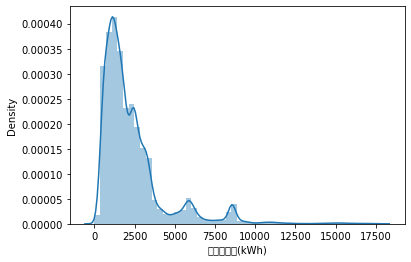

In [18]:
sns.distplot(train.iloc[:, 2])